In [1]:
# import libraries

import pandas as pd
import numpy as np
import re
import random
from datetime import datetime
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,DoubleType,TimestampType,VarcharType
from pyspark.sql.functions import *
import requests
import matplotlib.pyplot as plt
import credential

In [2]:
spark = SparkSession.builder \
    .appName("PySpark MySQL Connection") \
    .config("spark.jars", "C:\Spark\jars\mysql-connector-j-8.0.33.jar") \
    .getOrCreate()

In [3]:
# Overview of LOAN Application Data API
# Functional Requirements - LOAN Application Dataset

# 411 Create a Python program to GET (consume) data from the above API endpoint 
#for the loan application dataset.

url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"
response = (requests.get(url))
jfile = response.json()
application_df = spark.createDataFrame(jfile)

application_df.show(5)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [4]:
# Functional Requirements 4.2 - Find the status code of the above API endpoint.
# Hint: status code could be 200, 400, 404, 401.

# print request status_code
print(response)
print(response.status_code)

<Response [200]>
200


In [ ]:
# Functional Requirements 4.3 - Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL). 
#The table name should be CDW-SAPP_loan_application in the database.
#Note: Use the “creditcard_capstone” database.

application_df.write.format("jdbc") \
    .option("url", credential.jdbcapi) \
    .option("dbtable", "CDW_SAPP_loan_application") \
    .option("user", credential.username) \
    .option("password", credential.password) \
    .save()

#application_df.write.jdbc("jdbc:mysql://localhost:3306/creditcard_capstone", table="CDW-SAPP_loan_application",mode='append')

  Application_Status  count  percentage
0                  Y     46       65.71
1                  N     24       34.29


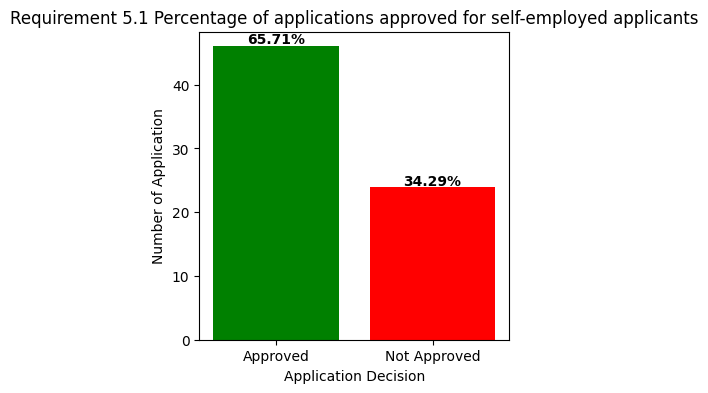

In [7]:
# Functional Requirements 5.1 - Find and plot the percentage of applications approved for self-employed applicants.

# filter current application df into df with only self employed people
df = application_df.filter(col("Self_Employed") == "Yes")

# create df which include total count of approved and not approved application and covert into Pandas DF
df2 = df.groupBy("Application_Status").count().toPandas()

# calculate and create column with percentage
total_application = df2["count"].sum()
df2["percentage"] = (df2["count"]/total_application *100).round(decimals = 2)

# create plot
plt.figure(figsize=(4,4))
colors_list = ['Green', 'Red']
graph = plt.bar(df2["Application_Status"],df2["count"], color = colors_list)
plt.title('Requirement 5.1 Percentage of applications approved for self-employed applicants')
plt.xlabel('Application Decision') # add to x-label to the plot
plt.ylabel('Number of Application') # add y-label to the plot

labels = ["Approved", "Not Approved"]
plt.xticks(df2["Application_Status"], labels)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(df2["percentage"][i])+'%',
             ha='center',
             weight='bold')
    i+=1

print(df2.head())
plt.show()

  Application_Status  count  percentage
0                  Y    219       71.57
1                  N     87       28.43


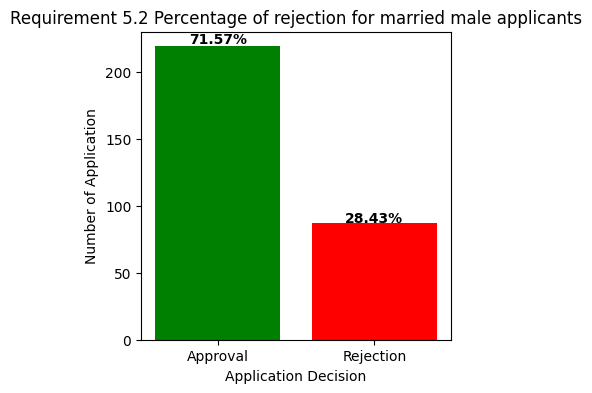

In [8]:
# Functional Requirements 5.2 - Find the percentage of rejection for married male applicants.
df3 = application_df.filter((col("Married") == "Yes") & (col("Gender")=="Male"))

# create df which include total count of approved and not approved application and covert into Pandas DF
df2 = df3.groupBy("Application_Status").count().toPandas()

# calculate and create column with percentage
total_application = df2["count"].sum()
df2["percentage"] = (df2["count"]/total_application *100).round(decimals = 2)

# create plot
plt.figure(figsize=(4,4))
colors_list = ['Green', 'Red']
graph = plt.bar(df2["Application_Status"],df2["count"], color = colors_list)
plt.title('Requirement 5.2 Percentage of rejection for married Male applicants')
plt.xlabel('Application Decision') # add to x-label to the plot
plt.ylabel('Number of Application') # add y-label to the plot

labels = ["Approval", "Rejection"]
plt.xticks(df2["Application_Status"], labels)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(df2["percentage"][i])+'%',
             ha='center',
             weight='bold')
    i+=1

print(df2.head())
plt.show()
